# Normalizing Flows

In this tutorial we will implement Normalizing Flows.

Normalizing Flows are a general framework for defining expressive probability distributions. They can be defined with simple base distribution and a series of invertable transformations and are trained using MLE.

Let's begin with a simple task: learn a mapping between two normal distributions.

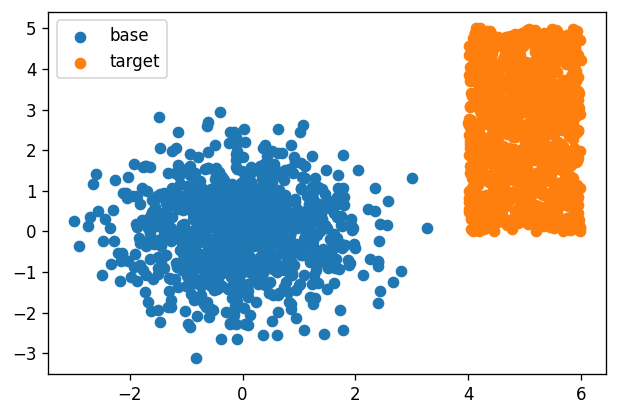

In [0]:
import torch
from torch import distributions as dist
import matplotlib.pyplot as plt
%matplotlib inline

# base distribution with known density
base = dist.Normal(torch.zeros(2), torch.ones(2))

# target distribution with "unknown" denisity
target = dist.Uniform(low=torch.tensor([4., 0.]), high=torch.tensor([6., 5.]))


plt.figure(dpi=120)
        
y = base.sample([1000])
plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="base")

y = target.sample([1000])
plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="target")

plt.legend()

## Change of variable change of volume rule

Let $z \in \mathbb{R}^d$ be a random variable with distribution $p_z(z)$ and $f: \mathbb{R}^d \rightarrow \mathbb{R}^d$ an invertible mapping from $z$ to $y$. We can define the distribution of the resulting variable $y = f(z)$ as follows:

$$ p_y(y) = p_z(f^{-1}(y)) \cdot \det | J(f^{-1}(y)) |$$

We can also compose a series of invertible mappings $f_1 \dotso f_n$ together. In this case the distribution of the resulting variable $y = f_n \circ \dotsb \circ f_1(z) = F(z)$ will be:

$$ p_y(y) = p_z(F^{-1}(y)) \cdot \prod_{n=1}^{N} |\det J (f_n^{-1}(y))|$$

Now the composition of these invertible mappings is called a "Normalizing Flow" and we can train it to learn the distribution of our data by maximizing the following expression:

$$ \sum_i \log p_y(y_i) = \sum_i (\log p_z(F^{-1}(y_)) + \sum_{n=1}^{N} \log |\det J (f_n^{-1}(y_i))|)$$

So let's build a Normalizing Flow!

In [0]:
import torch.nn.functional as F
from torch import nn, optim

# abstract flow class
class Flow(nn.Module):
    def __init__(self, size, base):
        super().__init__()
        
        self.size = size
        self.base = base
        
    def forward(self, x):
        raise NotImplementedError
        
    def inverse(self, y):
        raise NotImplementedError
        
    def sample(self, shape):
        x = self.base.sample(shape)
        return self(x)
    
    def log_prob(self, y):
        x, ldij = self.inverse(y)
        return self.base.log_prob(x) + ldij

In [0]:
# basically an affine flow
class LinearFlow(Flow):
    def __init__(self, size, base):
        super(self.__class__, self).__init__(size, base)
               
        self.linear = nn.Linear(size, size)
    
    def forward(self, x):
        return self.linear(x)

    def inverse(self, y):
        batch = y.shape[0]
        inverse_weight = torch.inverse(self.linear.weight)
        x = F.linear(y - self.linear.bias, inverse_weight)
        ldij = torch.log(1 / self.linear.weight.det().abs()).view(1, 1)
        return x, ldij


class LeakyReLUFlow(Flow):
    def __init__(self, size, base, negative_slope=0.01):
        super(self.__class__, self).__init__(size, base)
        
        self.negative_slope = negative_slope
        
    def forward(self, x):
        return torch.where(x >= 0, x, x * self.negative_slope)
        
    def inverse(self, y):
        i = torch.ones_like(y)
        j_inv = torch.where(y >= 0, i, 1.0 / self.negative_slope * i)
        
        return torch.where(y >= 0, y, 1. / self.negative_slope * y),\
               torch.log(j_inv.abs()).sum(1, keepdim=True)

In [0]:
flow = base
for i in range(2):
  flow = LinearFlow(2, flow)
  flow = LeakyReLUFlow(2, flow)
flow = LinearFlow(2, flow)

optimizer = optim.Adam(flow.parameters(), lr=1e-3)

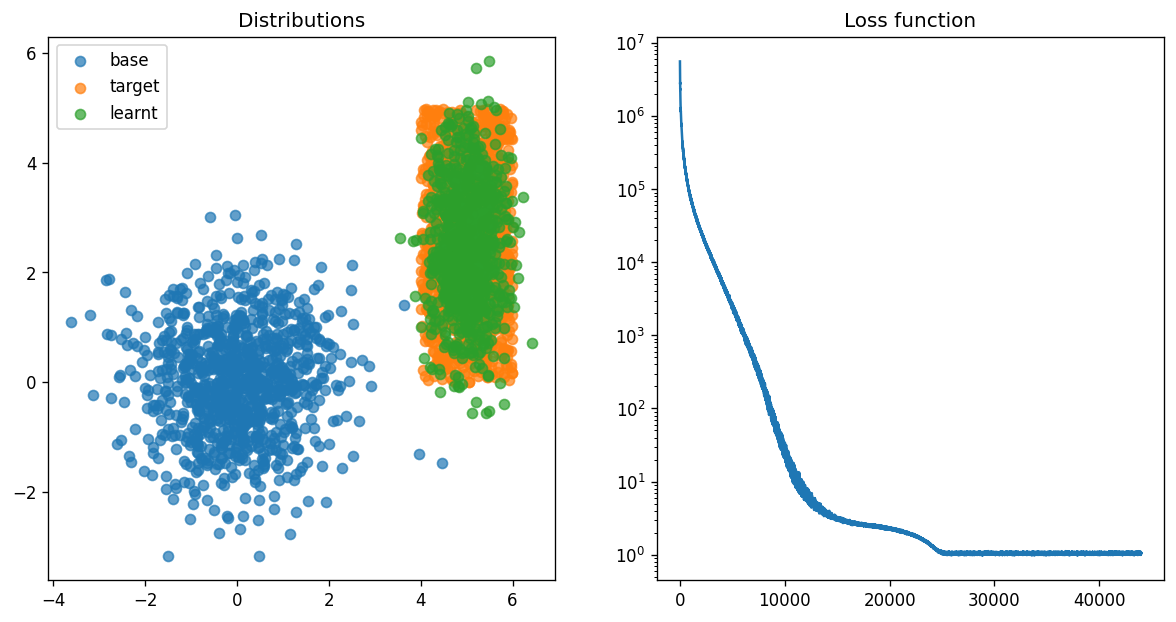

In [0]:
from IPython.display import clear_output

epoch = 0
loss_history = list()

while True:
    optimizer.zero_grad()
    
    y = target.sample([1000])
    # minimize -log p(data)
    loss = -flow.log_prob(y).mean()
    loss.backward()
    
    optimizer.step()
    
    epoch += 1
    loss_history.append(loss.item())
    if epoch % 500 == 0:
        clear_output(True)
        
        plt.figure(figsize=[12, 6], dpi=120)
        plt.subplot(1, 2, 1)
        plt.title("Distributions")
        
        y = base.sample([1000])
        plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="base", alpha=.7)

        y = target.sample([1000])
        plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="target", alpha=.7)

        y = flow.sample([1000])
        plt.scatter(y.data.numpy().T[0], y.data.numpy().T[1], label="learnt", alpha=.7)

        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("Loss function")
        plt.plot(loss_history)
        plt.yscale('log')
        plt.show()

Author: [Denis Mazur](https://github.com/deniskamazur)

More on normalizing flows:
 * [Normalizing Flows Tutorial by Eric Jang](https://blog.evjang.com/2018/01/nf1.html)
 * [An in-depth overview of everything Normalizing Flow related by Papamakarios et al.](https://arxiv.org/pdf/1912.02762.pdf)
 * [Convolutional Normalizing Flows for image generation](https://openai.com/blog/glow/)
 * [Continuous time Normalizing Flows](https://arxiv.org/pdf/1810.01367.pdf)
